**Imports & Global Configuration**

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
DATASET_ROOT = "/kaggle/input/datasetcavitydetection/Dental_Cavity_Dataset"

TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
TEST_DIR  = os.path.join(DATASET_ROOT, "test")


**Verify Folder Structure**

In [3]:
def check_structure(base_dir):
    print(f"\nChecking structure: {base_dir}")
    if not os.path.exists(base_dir):
        print("❌ Directory does not exist")
        return

    classes = sorted(os.listdir(base_dir))
    print("Classes found:", classes)

    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_path):
            print(f"❌ {cls} is not a directory")
        else:
            print(f"✅ {cls}/ contains {len(os.listdir(cls_path))} files")

check_structure(TRAIN_DIR)
check_structure(TEST_DIR)



Checking structure: /kaggle/input/datasetcavitydetection/Dental_Cavity_Dataset/train
Classes found: ['Cavity', 'Non_Cavity']
✅ Cavity/ contains 14008 files
✅ Non_Cavity/ contains 10330 files

Checking structure: /kaggle/input/datasetcavitydetection/Dental_Cavity_Dataset/test
Classes found: ['Cavity', 'Non_Cavity']
✅ Cavity/ contains 6287 files
✅ Non_Cavity/ contains 4056 files


**Class Distribution**

In [4]:
def count_images(base_dir):
    counts = {}
    for cls in sorted(os.listdir(base_dir)):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len([
                f for f in os.listdir(cls_path)
                if f.lower().endswith((".jpg", ".png", ".jpeg"))
            ])
    return counts

train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

print("\nTrain distribution:", train_counts)
print("Test distribution:", test_counts)



Train distribution: {'Cavity': 14008, 'Non_Cavity': 10330}
Test distribution: {'Cavity': 6287, 'Non_Cavity': 4056}


**Visualize Class Imbalance**

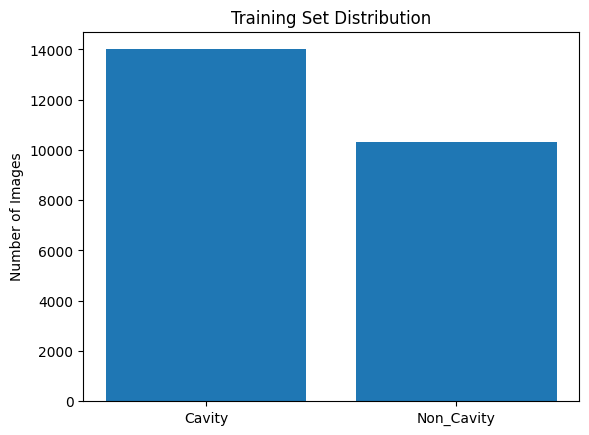

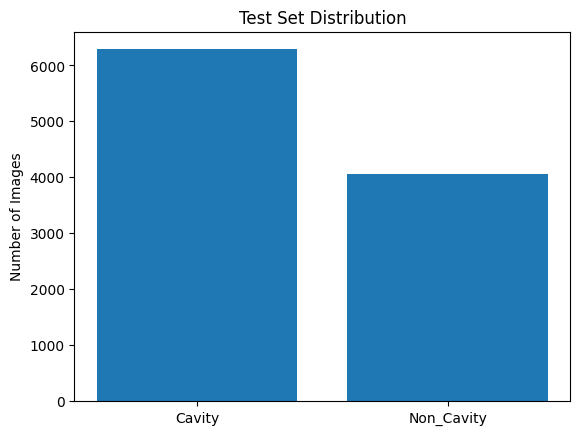

In [5]:
def plot_distribution(counts, title):
    labels = list(counts.keys())
    values = list(counts.values())

    plt.bar(labels, values)
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.show()

plot_distribution(train_counts, "Training Set Distribution")
plot_distribution(test_counts, "Test Set Distribution")


**Check for Corrupt Images**

In [6]:
def check_corrupt_images(base_dir):
    corrupt = []
    total = 0

    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            total += 1
            try:
                with Image.open(img_path) as img:
                    img.verify()
            except:
                corrupt.append(img_path)

    print(f"\nChecked {total} images")
    print(f"Corrupt images found: {len(corrupt)}")

    if corrupt:
        print("Examples:")
        for c in corrupt[:5]:
            print(" -", c)

check_corrupt_images(TRAIN_DIR)
check_corrupt_images(TEST_DIR)



Checked 24338 images
Corrupt images found: 0

Checked 10343 images
Corrupt images found: 0


**Image Size Statistics**

In [7]:
def image_size_stats(base_dir, sample_limit=500):
    widths, heights = [], []
    count = 0

    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        for img_name in os.listdir(cls_path):
            if count >= sample_limit:
                break
            img_path = os.path.join(cls_path, img_name)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
                    count += 1
            except:
                continue

    print(f"\nImage size stats (sampled {count} images):")
    print(f"Width  → min: {min(widths)}, max: {max(widths)}, mean: {np.mean(widths):.1f}")
    print(f"Height → min: {min(heights)}, max: {max(heights)}, mean: {np.mean(heights):.1f}")

image_size_stats(TRAIN_DIR)



Image size stats (sampled 500 images):
Width  → min: 640, max: 1024, mean: 701.4
Height → min: 640, max: 1024, mean: 701.4


**Dataset Sanity Warnings**

In [8]:
def sanity_checks(train_counts, test_counts):
    print("\nSanity checks:")

    if set(train_counts.keys()) != set(test_counts.keys()):
        print("❌ Train/Test classes do not match")

    for cls in train_counts:
        ratio = test_counts[cls] / (train_counts[cls] + test_counts[cls])
        if ratio < 0.2 or ratio > 0.4:
            print(f"⚠️ Unusual split ratio for class '{cls}': {ratio:.2f}")

    print("✅ Sanity check complete")

sanity_checks(train_counts, test_counts)



Sanity checks:
✅ Sanity check complete


**Reproducibility & Device**

In [9]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


**Hyperparameters**

In [10]:
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS_FROZEN = 5
NUM_EPOCHS_FINETUNE = 20
LR_FROZEN = 1e-3
LR_FINETUNE = 1e-4
PATIENCE = 6  # Early stopping patience


**Transforms (NO leakage)**

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


**Dataset Paths**

In [12]:
TRAIN_DIR = "/kaggle/input/datasetcavitydetection/Dental_Cavity_Dataset/train"
TEST_DIR  = "/kaggle/input/datasetcavitydetection/Dental_Cavity_Dataset/test"


**Dataloaders + Stratified Validation**

In [13]:
def get_dataloaders(train_dir, test_dir):
    full_train = datasets.ImageFolder(train_dir, transform=train_transform)
    targets = full_train.targets

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.15,
        stratify=targets,
        random_state=42
    )

    train_ds = Subset(full_train, train_idx)
    val_ds = Subset(
        datasets.ImageFolder(train_dir, transform=val_test_transform),
        val_idx
    )

    test_ds = datasets.ImageFolder(test_dir, transform=val_test_transform)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Class weights (train only)
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets)
    pos_weight = torch.tensor(
        class_counts[0] / class_counts[1],
        dtype=torch.float
    ).to(DEVICE)

    return train_loader, val_loader, test_loader, pos_weight


**Models (EfficientNet + ResNet)**

In [14]:
def get_efficientnet():
    model = models.efficientnet_b0(
        weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
    )
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 1)
    return model.to(DEVICE)

def get_resnet():
    model = models.resnet50(
        weights=models.ResNet50_Weights.IMAGENET1K_V1
    )
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 1)
    return model.to(DEVICE)


**Training & Evaluation Functions**

In [15]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for x, y in loader:
        x = x.to(DEVICE)
        y = y.float().to(DEVICE)

        optimizer.zero_grad()
        logits = model(x).squeeze()
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    for x, y in loader:
        x = x.to(DEVICE)
        y = y.float().to(DEVICE)

        logits = model(x).squeeze()
        probs = torch.sigmoid(logits)

        y_true.extend(y.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())
        y_pred.extend((probs > 0.5).cpu().numpy())

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_prob),
        "y_true": y_true,
        "y_prob": y_prob
    }


**Early Stopping**

In [16]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = np.inf
        self.counter = 0
        self.stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True


**Train Function (Freeze → Fine-Tune)**

In [17]:
def train_model(model, train_loader, val_loader, pos_weight):
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    early_stopping = EarlyStopping(PATIENCE)

    # 1. Identify the head dynamically
    if hasattr(model, 'classifier'):
        head = model.classifier  # EfficientNet
    else:
        head = model.fc          # ResNet

    # Phase 1: Freeze backbone
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze only the head we identified
    for param in head.parameters():
        param.requires_grad = True

    # Use head.parameters() specifically for the first phase optimizer
    optimizer = optim.Adam(head.parameters(), lr=LR_FROZEN)

    print(f"--- Phase 1: Training {type(model).__name__} Head ---")
    for epoch in range(NUM_EPOCHS_FROZEN):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        # We use evaluate here to check progress without training on validation data
        val_metrics = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val AUC {val_metrics['roc_auc']:.4f}")

    # Phase 2: Fine-tuning
    print(f"--- Phase 2: Fine-tuning {type(model).__name__} ---")
    for param in model.parameters():
        param.requires_grad = True

    optimizer = optim.AdamW(model.parameters(), lr=LR_FINETUNE)

    for epoch in range(NUM_EPOCHS_FINETUNE):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        
        # Proper validation check
        val_metrics = evaluate(model, val_loader)
        # Using 1 - AUC as a loss proxy for early stopping
        early_stopping(1 - val_metrics['roc_auc']) 
        
        print(f"FT Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val AUC {val_metrics['roc_auc']:.4f}")

        if early_stopping.stop:
            print("Early stopping triggered.")
            break

**Run Experiments (EfficientNet + ResNet)**

In [18]:
train_loader, val_loader, test_loader, pos_weight = get_dataloaders(
    TRAIN_DIR, TEST_DIR
)

# EfficientNet
eff_model = get_efficientnet()
train_model(eff_model, train_loader, val_loader, pos_weight)
eff_results = evaluate(eff_model, test_loader)

# ResNet baseline
res_model = get_resnet()
train_model(res_model, train_loader, val_loader, pos_weight)
res_results = evaluate(res_model, test_loader)

print("EfficientNet Test:", eff_results)
print("ResNet Test:", res_results)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


--- Phase 1: Training EfficientNet Head ---
Epoch 1: Train Loss 0.6226, Val AUC 0.8305
Epoch 2: Train Loss 0.5870, Val AUC 0.8453
Epoch 3: Train Loss 0.5793, Val AUC 0.8460
Epoch 4: Train Loss 0.5691, Val AUC 0.8504
Epoch 5: Train Loss 0.5741, Val AUC 0.8458
--- Phase 2: Fine-tuning EfficientNet ---
FT Epoch 1: Train Loss 0.4557, Val AUC 0.9453
FT Epoch 2: Train Loss 0.3374, Val AUC 0.9555
FT Epoch 3: Train Loss 0.2781, Val AUC 0.9611
FT Epoch 4: Train Loss 0.2493, Val AUC 0.9678
FT Epoch 5: Train Loss 0.2209, Val AUC 0.9664
FT Epoch 6: Train Loss 0.2048, Val AUC 0.9674
FT Epoch 7: Train Loss 0.1966, Val AUC 0.9721
FT Epoch 8: Train Loss 0.1781, Val AUC 0.9712
FT Epoch 9: Train Loss 0.1676, Val AUC 0.9695
FT Epoch 10: Train Loss 0.1633, Val AUC 0.9710
FT Epoch 11: Train Loss 0.1559, Val AUC 0.9712
FT Epoch 12: Train Loss 0.1508, Val AUC 0.9730
FT Epoch 13: Train Loss 0.1429, Val AUC 0.9714
FT Epoch 14: Train Loss 0.1407, Val AUC 0.9735
FT Epoch 15: Train Loss 0.1363, Val AUC 0.9736
FT 

100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


--- Phase 1: Training ResNet Head ---
Epoch 1: Train Loss 0.6267, Val AUC 0.8383
Epoch 2: Train Loss 0.5931, Val AUC 0.8445
Epoch 3: Train Loss 0.5810, Val AUC 0.8475
Epoch 4: Train Loss 0.5777, Val AUC 0.8491
Epoch 5: Train Loss 0.5718, Val AUC 0.8558
--- Phase 2: Fine-tuning ResNet ---
FT Epoch 1: Train Loss 0.4672, Val AUC 0.9245
FT Epoch 2: Train Loss 0.3692, Val AUC 0.9439
FT Epoch 3: Train Loss 0.3115, Val AUC 0.9483
FT Epoch 4: Train Loss 0.2819, Val AUC 0.9545
FT Epoch 5: Train Loss 0.2653, Val AUC 0.9500
FT Epoch 6: Train Loss 0.2489, Val AUC 0.9570
FT Epoch 7: Train Loss 0.2347, Val AUC 0.9623
FT Epoch 8: Train Loss 0.2264, Val AUC 0.9614
FT Epoch 9: Train Loss 0.2138, Val AUC 0.9591
FT Epoch 10: Train Loss 0.1981, Val AUC 0.9583
FT Epoch 11: Train Loss 0.1972, Val AUC 0.9623
FT Epoch 12: Train Loss 0.1851, Val AUC 0.9562
FT Epoch 13: Train Loss 0.1849, Val AUC 0.9637
FT Epoch 14: Train Loss 0.1813, Val AUC 0.9632
FT Epoch 15: Train Loss 0.1721, Val AUC 0.9621
FT Epoch 16: Tr

**Confusion Matrix & ROC Curve**

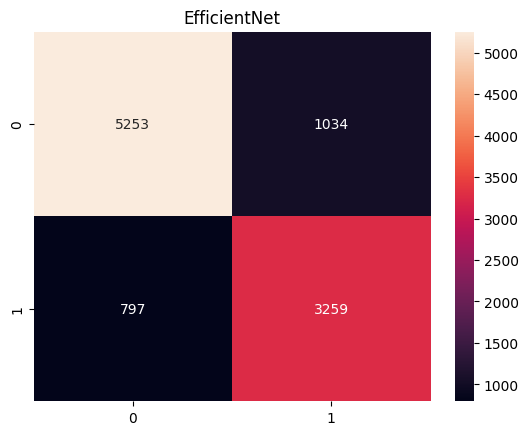

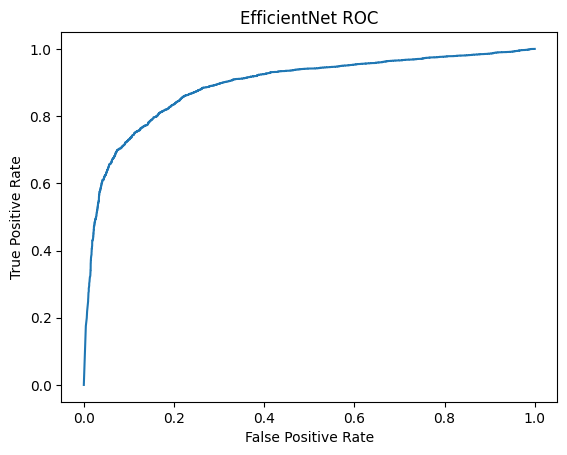

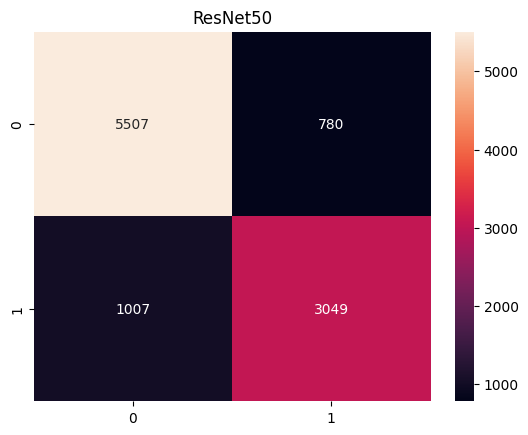

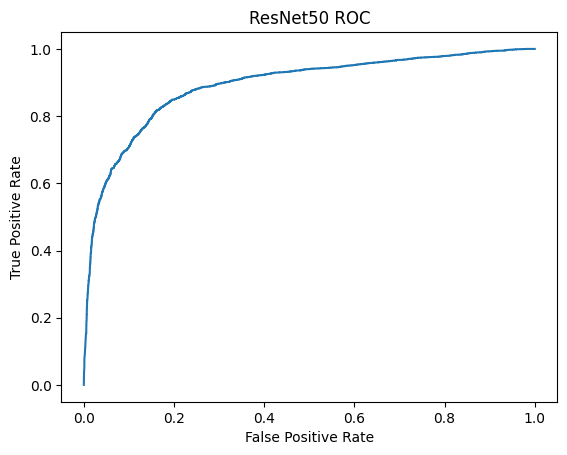

In [19]:
def plot_results(results, title):
    cm = confusion_matrix(results["y_true"], np.array(results["y_prob"]) > 0.5)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.show()

    fpr, tpr, _ = roc_curve(results["y_true"], results["y_prob"])
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title + " ROC")
    plt.show()

plot_results(eff_results, "EfficientNet")
plot_results(res_results, "ResNet50")


Metric          | EfficientNet    | ResNet         
--------------------------------------------------
Accuracy        | 0.8230          | 0.8272         
Precision       | 0.7591          | 0.7963         
Recall          | 0.8035          | 0.7517         
F1              | 0.7807          | 0.7734         
Roc_auc         | 0.8921          | 0.8921         


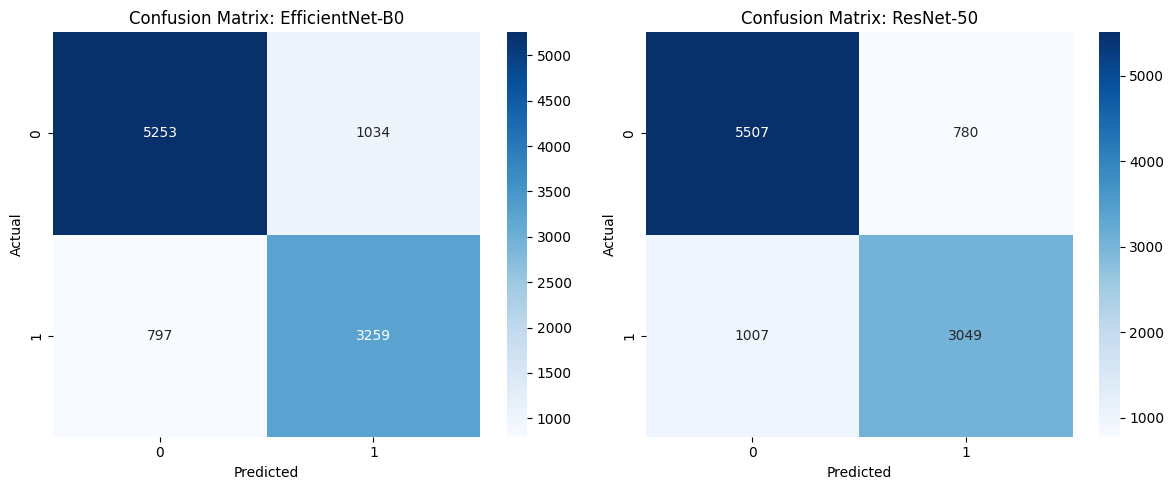

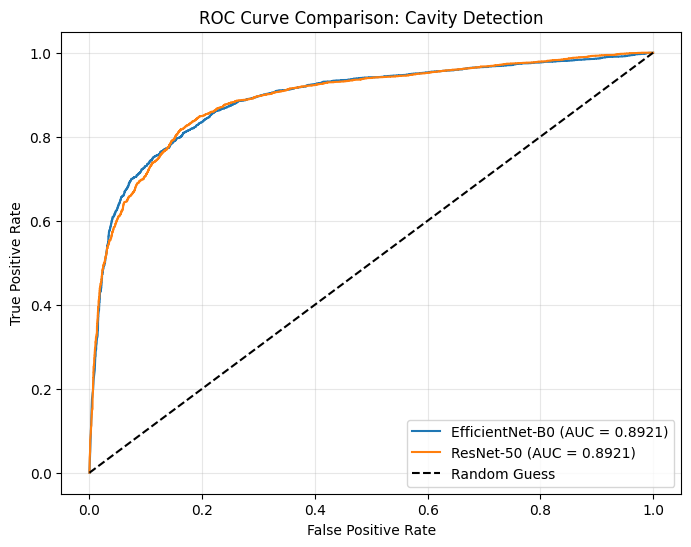

In [20]:
def plot_comparative_metrics(eff_results, res_results):
    # 1. Print Text Summary
    models = ['EfficientNet-B0', 'ResNet-50']
    results = [eff_results, res_results]
    
    print(f"{'Metric':<15} | {'EfficientNet':<15} | {'ResNet':<15}")
    print("-" * 50)
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        print(f"{metric.capitalize():<15} | {eff_results[metric]:<15.4f} | {res_results[metric]:<15.4f}")

    # 2. Plot Side-by-Side Confusion Matrices
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    for i, (res, name) in enumerate(zip(results, models)):
        cm = confusion_matrix(res['y_true'], (np.array(res['y_prob']) > 0.5).astype(int))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[i])
        ax[i].set_title(f'Confusion Matrix: {name}')
        ax[i].set_xlabel('Predicted')
        ax[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # 3. Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for res, name in zip(results, models):
        fpr, tpr, _ = roc_curve(res['y_true'], res['y_prob'])
        plt.plot(fpr, tpr, label=f"{name} (AUC = {res['roc_auc']:.4f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison: Cavity Detection')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Run the evaluation
plot_comparative_metrics(eff_results, res_results)